In [4]:
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import copy

['Austin Running 160spm, 12kph.csv']


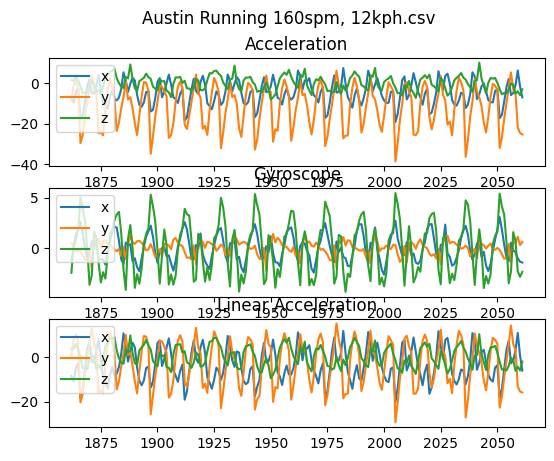

In [15]:
def take_sample_window():
       Viable_Cols = ['Acceleration x (m/s^2)_kalman', 'Acceleration y (m/s^2)_kalman', 'Acceleration z (m/s^2)_kalman', 'Gyroscope x (rad/s)_kalman',
              'Gyroscope y (rad/s)_kalman', 'Gyroscope z (rad/s)_kalman', 'Linear Acceleration x (m/s^2)_kalman',
              'Linear Acceleration y (m/s^2)_kalman', 'Linear Acceleration z (m/s^2)_kalman']
       files = os.listdir('./Group_71_Data_Kalman')
       file = random.sample(files, 1)
       print(file)
       frame = pd.read_csv('./Group_71_Data_Kalman/'+file[0])
       start = random.randint(100,len(frame['Acceleration x (m/s^2)'])-200)
       fig, axs = plt.subplots(3)
       axs[0].plot(range(start,start+200),frame['Acceleration x (m/s^2)_kalman'][start:start+200], label='x')
       axs[0].plot(range(start,start+200),frame['Acceleration y (m/s^2)_kalman'][start:start+200], label='y')
       axs[0].plot(range(start,start+200),frame['Acceleration z (m/s^2)_kalman'][start:start+200], label='z')
       axs[0].set_title("Acceleration")
       axs[0].legend(loc='upper left')
       axs[1].plot(range(start,start+200),frame['Gyroscope x (rad/s)_kalman'][start:start+200], label='x')
       axs[1].plot(range(start,start+200),frame['Gyroscope y (rad/s)_kalman'][start:start+200], label='y')
       axs[1].plot(range(start,start+200),frame['Gyroscope z (rad/s)_kalman'][start:start+200], label='z')
       axs[1].set_title("Gyroscope")
       axs[1].legend(loc='upper left')
       axs[2].plot(range(start,start+200),frame['Linear Acceleration x (m/s^2)_kalman'][start:start+200], label='x')
       axs[2].plot(range(start,start+200),frame['Linear Acceleration y (m/s^2)_kalman'][start:start+200], label='y')
       axs[2].plot(range(start,start+200),frame['Linear Acceleration z (m/s^2)_kalman'][start:start+200], label='z')
       axs[2].set_title("Linear Acceleration")
       axs[2].legend(loc='upper left')
       plt.suptitle(file[0])
       plt.show()

#for i in range(10):
take_sample_window()


In [17]:
import numpy as np
import pandas as pd

# This class performs a Fourier transformation on the data to find frequencies that occur
# often and filter noise.
class FourierTransformation:
    
    def __init__(self):
        self.temp_list = []
        self.freqs = None

    def find_fft_transformation(self, series):
        transformation = np.fft.rfft(series, len(series))
        real_ampl = transformation.real
        max_freq = self.freqs[np.argmax(real_ampl[0:len(real_ampl)])]
        freq_weigthed = float(np.sum(self.freqs * real_ampl)) / np.sum(real_ampl)

        PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
        PSD_pdf = np.divide(PSD, np.sum(PSD))

        if np.count_nonzero(PSD_pdf) == PSD_pdf.size:
            pse = -np.sum(np.log(PSD_pdf) * PSD_pdf)
        else:
            pse = 0

        real_ampl = np.insert(real_ampl, 0, max_freq)
        real_ampl = np.insert(real_ampl, 0, freq_weigthed)
        row = np.insert(real_ampl, 0, pse)

        self.temp_list.append(row)

        return 0

    def abstract_frequency(self, data_table, columns, window_size, sampling_rate):
        self.freqs = (sampling_rate * np.fft.rfftfreq(int(window_size))).round(3)

        for col in columns:
            collist = []
            # prepare column names
            collist.append(col + '_max_freq')
            collist.append(col + '_freq_weighted')
            collist.append(col + '_pse')
            
            collist = collist + [col + '_freq_' +
                    str(freq) + '_Hz_ws_' + str(window_size) for freq in self.freqs]
           
            # rolling statistics to calculate frequencies, per window size. 
            # Pandas Rolling method can only return one aggregation value. 
            # Therefore values are not returned but stored in temp class variable 'temp_list'.

            # note to self! Rolling window_size would be nicer and more logical! In older version windowsize is actually 41. (ws + 1)
            data_table[col].rolling(
                window_size + 1).apply(self.find_fft_transformation)

            # Pad the missing rows with nans
            frequencies = np.pad(np.array(self.temp_list), ((window_size, 0), (0, 0)),
                        'constant', constant_values=np.nan)
            # add new freq columns to frame
            
            data_table[collist] = pd.DataFrame(frequencies, index=data_table.index)

            # reset temp-storage array
            del self.temp_list[:]
            

        
        return data_table

In [ ]:
fourrier = FourierTransformation()
Viable_Cols = ['Acceleration x (m/s^2)_kalman', 'Acceleration y (m/s^2)_kalman', 'Acceleration z (m/s^2)_kalman', 'Gyroscope x (rad/s)_kalman',
              'Gyroscope y (rad/s)_kalman', 'Gyroscope z (rad/s)_kalman', 'Linear Acceleration x (m/s^2)_kalman',
              'Linear Acceleration y (m/s^2)_kalman', 'Linear Acceleration z (m/s^2)_kalman']
col = random.sample(Viable_Cols, 1)
print(col)
files = os.listdir('./Group_71_Data_Kalman')
file = random.sample(files, 1)
milliseconds_per_instance = 50
print(file)
fs = float(1000)/milliseconds_per_instance
ws = int(float(10000)/milliseconds_per_instance)
frame = pd.read_csv('./Group_71_Data_Kalman/'+file[0])
print(frame.shape)
newframe = fourrier.abstract_frequency(frame, [col[0]], ws, fs)
print(newframe.shape)
newCol = str(col[0]+'_max_freq')
#plt.figure()
#plt.plot(range(len(newframe[newCol])),newframe[newCol])
#plt.savefig()
#plt.plot(range(len(newframe[col])),newframe[col])
#print(newframe.columns)
#print(newframe[newframe.columns[-1]])
#newframe.to_csv('FourrierTest.csv')
#for file in files:
for file in files:
    print("A")
    frame = pd.read_csv('./Group_71_Data_Kalman/'+str(file))
    newFrame = copy.deepcopy(frame)
    for i, column in enumerate(Viable_Cols):
        fourrier.abstract_frequency(newFrame, [column], ws, fs)
        newCol = str(column+'_max_freq')
        frame[newCol] = newFrame[newCol]
        #plt.figure()
        #plt.plot(range(len(newFrame[newCol])),newFrame[newCol])
        #lt.xlabel(str(file)+" Fourrier "+str(column))
        #plt.savefig("./Fourrier/Fourrier "+str(file)+" "+str(i)+".png")
    frame.to_csv("./Fourrier/Fourrier "+str(file))


In [53]:
Viable_Cols = ['Acceleration x (m/s^2)_kalman', 'Acceleration y (m/s^2)_kalman', 'Acceleration z (m/s^2)_kalman', 'Gyroscope x (rad/s)_kalman',
              'Gyroscope y (rad/s)_kalman', 'Gyroscope z (rad/s)_kalman', 'Linear Acceleration x (m/s^2)_kalman',
              'Linear Acceleration y (m/s^2)_kalman', 'Linear Acceleration z (m/s^2)_kalman']
files = os.listdir('./Fourrier/')
print(files)
files2 = []
for i in range(int(len(files)/10)):
    files2.append(files[i*10])
print(files2)
next = random.sample(files2, 1)
print(next)
frame = pd.read_csv('./Fourrier/'+next[0]) 
cad = frame['SPM/RPM'][1]
print(cad)
predictionGroups = []
means = []
means2 = []
lengths = []
Viable_Cols2 = []
clusters = []
clusterGroups = []
variance = []
vc = []
print(Viable_Cols)
over, count = 0, 0
for column in Viable_Cols:
    count += 1
    predictions = []
    newCol = str(column+'_max_freq')
    Viable_Cols2.append(newCol)
    for i in range(int(len(frame[newCol]))):
        if i%200 == 0 and i != 0:
            clusters.append(np.mean(predictions[i-100:i]))
        if np.mean(frame[newCol][i-200:i]) > 0:
            predictions.append(np.mean(frame[newCol][i-200:i])*60)
        variance.append(np.var(frame[newCol][i-200:i]))
    predictionGroups.append(predictions)
    means.append(np.mean(predictions))
    vc.append(variance)
    means2.append(np.mean(frame[newCol][-len(predictions):])*60)
    clusterGroups.append(clusters)
print(means)
print(means2)
print(np.mean(means))
votes = []
variance1 = []
variance2 = []
for i in range(len(predictionGroups[0])):
    count += 1
    avg = np.mean([col[i] for col in predictionGroups])
    avgVar = np.mean([col[i] for col in vc])
    if avg >= cad:
        variance1.append(avgVar)
        over += 1
    elif avgVar > 0:
        variance2.append(avgVar)
    else:
        count -= 1
    votes.append(avg)
print(variance1)
print(variance2)
print(votes)
print(np.mean(variance1)*60)
print(np.mean(variance2)*60)
print(over/count)


#print(predictions)
#print(np.mean(predictions))

['Fourrier Austin Biking 30rpm.csv', 'Fourrier Austin Biking 30rpm.csv 0.png', 'Fourrier Austin Biking 30rpm.csv 1.png', 'Fourrier Austin Biking 30rpm.csv 2.png', 'Fourrier Austin Biking 30rpm.csv 3.png', 'Fourrier Austin Biking 30rpm.csv 4.png', 'Fourrier Austin Biking 30rpm.csv 5.png', 'Fourrier Austin Biking 30rpm.csv 6.png', 'Fourrier Austin Biking 30rpm.csv 7.png', 'Fourrier Austin Biking 30rpm.csv 8.png', 'Fourrier Austin Biking 60rpm.csv', 'Fourrier Austin Biking 60rpm.csv 0.png', 'Fourrier Austin Biking 60rpm.csv 1.png', 'Fourrier Austin Biking 60rpm.csv 2.png', 'Fourrier Austin Biking 60rpm.csv 3.png', 'Fourrier Austin Biking 60rpm.csv 4.png', 'Fourrier Austin Biking 60rpm.csv 5.png', 'Fourrier Austin Biking 60rpm.csv 6.png', 'Fourrier Austin Biking 60rpm.csv 7.png', 'Fourrier Austin Biking 60rpm.csv 8.png', 'Fourrier Austin Biking 90rpm.csv', 'Fourrier Austin Biking 90rpm.csv 0.png', 'Fourrier Austin Biking 90rpm.csv 1.png', 'Fourrier Austin Biking 90rpm.csv 2.png', 'Fourrier

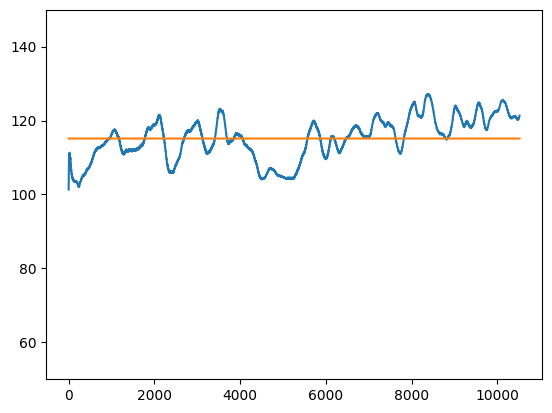

<Figure size 640x480 with 0 Axes>

In [58]:
plt.figure()
plt.plot(range(len(votes)),votes)
plt.ylim(50,150)
plt.plot(range(len(votes)),[np.mean(votes) for vote in votes])
plt.show()
plt.savefig('averaged cadence.png')

In [60]:
window_data = []
label_groups = []
files3 = random.sample(files2, 1)
for file in files3:
    print(file)
    samples = []
    labels = []
    frame = pd.read_csv('./Fourrier/'+str(file))
    frame = pd.read_csv('./Fourrier/Fourrier Austin Running 160spm, 12kph.csv')
    for i in range(202,len(frame[Viable_Cols2[1]])):
        miniFrame = pd.DataFrame()
        for col in Viable_Cols:
            miniFrame[col] = frame[col][i-200:i]
        for col in Viable_Cols2:
            miniFrame[col] = frame[col][i]    
        miniFrame['label'] = frame['SPM/RPM'][i]
        labels.append(frame['SPM/RPM'][i])
        samples.append(miniFrame)
    label_groups.append(labels)
    window_data.append(samples)

        
    
  
    

Fourrier Georgios Walking Outside 30spm.csv


-35.9191042207402
Error abs: 45.92920013945197
[43.001395440607126, 43.79838697953991, 32.72459182312599, 21.270137113230817, 12.934987554763524, 20.46330653331509, 40.339870489581216, 49.560185978243055, 43.78149889801932, 46.88435718904233, 25.337501135724096, 12.737740634726691, 20.959355179035157, 27.966124549635083, 40.43318638044133, 50.42123824863589, 43.92575685523852, 29.751511115080262, 15.692842815842994, 9.1274522537052, 17.327283204768122, 37.25000425094902, 55.919231699586476, 52.12892896514941, 32.74088003542647, 24.665627720888494, 6.773080822614531, 6.232734657112189, 7.6127374704635145, 32.825947913248456, 48.41874618793656, 36.90805698632681, 21.501896645949984, 15.339048228024296, 4.814507940526369, -0.33081203143973426, 10.569332896741514, 39.744003778216694, 50.386065878812246, 21.238128874577313, 12.860178284533703, 3.631736826010666, -0.8842025722222786, -0.853816168972628, 11.42210529295079, 52.3981743236815, 43.98700179579782, 16.654131721170813, 3.97244108548

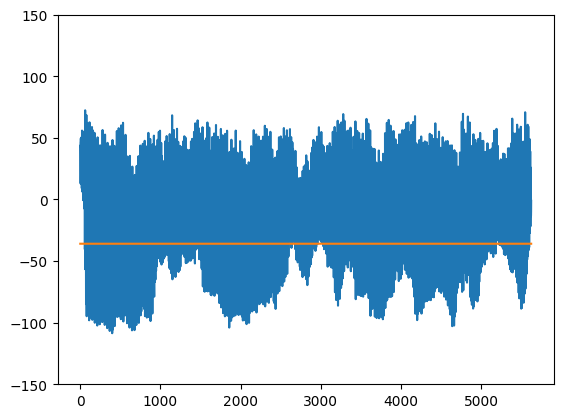

In [67]:
errors_abs = []
errors = []
for sample in window_data[0]:
    #error = np.mean([sample[col].iloc[1] for col in Viable_Cols2])*60 - 160
    error = sample['Gyroscope x (rad/s)_kalman_max_freq'].iloc[1]*60 - 160
    errors.append(error)
    errors_abs.append(np.abs(error))
print(np.mean(errors))
print("Error abs: "+str(np.mean(errors_abs)))
print(errors)
plt.figure()
plt.plot(range(len(errors)),errors)
plt.ylim(-150,150)
plt.plot(range(len(errors)),[np.mean(errors) for error in errors])
plt.show()


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

PCA_explained = []
print(files2)
for file in files2:
    df = pd.read_csv('./Fourrier/'+str(file))
    df = df[Viable_Cols]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    pca = PCA()
    pca.fit(scaled_data)
    PCA_explained.append(np.cumsum(pca.explained_variance_ratio_))
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')  # for each component
    plt.title('Explained Variance')
    #plt.show()
    plt.savefig('./PCA/'+str(file[:-4])+".png")




[0.3508690426547848, 0.5920870829001512, 0.7349565056069466, 0.8342152496786369, 0.8975416242457588, 0.941565825248237, 0.969731056200271, 0.9897167166833979, 1.0]


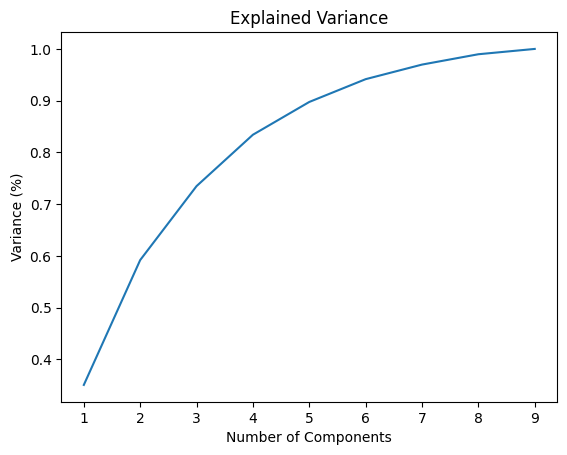

In [31]:
averages = []
for i in range(len(PCA_explained[0])):
    pca_avg = np.mean([PCA[i] for PCA in PCA_explained])
    averages.append(pca_avg)
print(averages)
plt.figure()
plt.plot(range(1,10),averages)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.savefig('Explained Variance PCA.png')